In [47]:
import yaml
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [48]:
class CosineScheduler():
    def __init__(
        self,
        lr_warmup_steps: int,
        lr: float,
        final_lr_step: int,
        final_lr_fraction: float,
        ratio_lr,
        scheduler_fraction,
    ):
        self.lr_warmup_steps = lr_warmup_steps
        self.lr = lr
        self.final_lr_step = final_lr_step
        self.final_lr_fraction = final_lr_fraction
        self.ratio = ratio_lr
        self.fraction = scheduler_fraction

    def get_lr(self, step: int, start_lr=None, end_lr=None):
        start_lr = start_lr if start_lr is not None else self.lr
        end_lr = end_lr if end_lr is not None else self.lr * self.final_lr_fraction

        if step < self.lr_warmup_steps:
            return start_lr * (step + 1) / self.lr_warmup_steps
        # cosine schedule that ends at final_lr_fraction * lr, then constant
        elif step < self.final_lr_step:
            return end_lr + 0.5 * (1 - end_lr/start_lr) * start_lr * (
                1
                + math.cos(
                    math.pi
                    * (step - self.lr_warmup_steps)
                    / (self.final_lr_step - self.lr_warmup_steps)
                )
            )
        else:
            return end_lr

    # had to overwrite it here, because AbstractLRScheduler doesn't know final_lr_fraction and othr params necessary for relative lr fractions
    def set_lr(self, step: int):
        
        start_lr = self.lr * self.ratio
        end_lr = self.lr * self.final_lr_fraction * self.fraction
        return self.get_lr(step, start_lr=start_lr, end_lr=end_lr)


In [49]:
def extract_learning_rate(yaml_file):
    with open(yaml_file, 'r') as file:
        config = yaml.safe_load(file)

    # Extract the learning rate
    main_dict = {}
    main_dict['lr'] = config.get('params', {}).get('learning_rate', None)
    main_dict['fraction'] = config.get('params', {}).get('final_lr_fraction', None)

    other_dict = {}
    other_dict['n_steps'] = config.get('params', {}).get('n_steps', None)
    other_dict['lr_warmup_steps'] = config.get('params', {}).get('lr_warmup_steps', None)

    relative_lr_dict = config.get('params', {}).get('relative_lr', None)
    relative_fraction_dict = config.get('params', {}).get('relative_scheduler_fraction', None)

    relative_dict = {}
    all_keys = set(relative_lr_dict.keys()).union(set(relative_fraction_dict.keys()))
    for key in all_keys:
        relative_dict[key] = {
            'lr': relative_lr_dict.get(key, 1.0),
            'fraction': relative_fraction_dict.get(key, 1.0)
        }

    relative_dict['base_lr'] = {'lr': 1.0, 'fraction': 1.0}

    return main_dict, relative_dict, other_dict


In [50]:
# Usage
yaml_file = 'configs/experiments/relative_lr/sota_relativity.yaml'  # Replace with your file path
main_dict, relative_dict, other_dict = extract_learning_rate(yaml_file)

print(main_dict)
print(relative_dict)
print(other_dict)

{'lr': 0.0005, 'fraction': 0.066666}
{'gating': {'lr': 0.666, 'fraction': 1.0}, 'expert_inner_function': {'lr': 0.3, 'fraction': 1.125}, 'projection': {'lr': 2.5, 'fraction': 1.0}, 'head': {'lr': 0.666, 'fraction': 0.666}, 'embedding_layer': {'lr': 3.333, 'fraction': 0.666}, 'base_lr': {'lr': 1.0, 'fraction': 1.0}}
{'n_steps': 41250, 'lr_warmup_steps': 412}


gating
expert_inner_function
projection
head
embedding_layer
base_lr


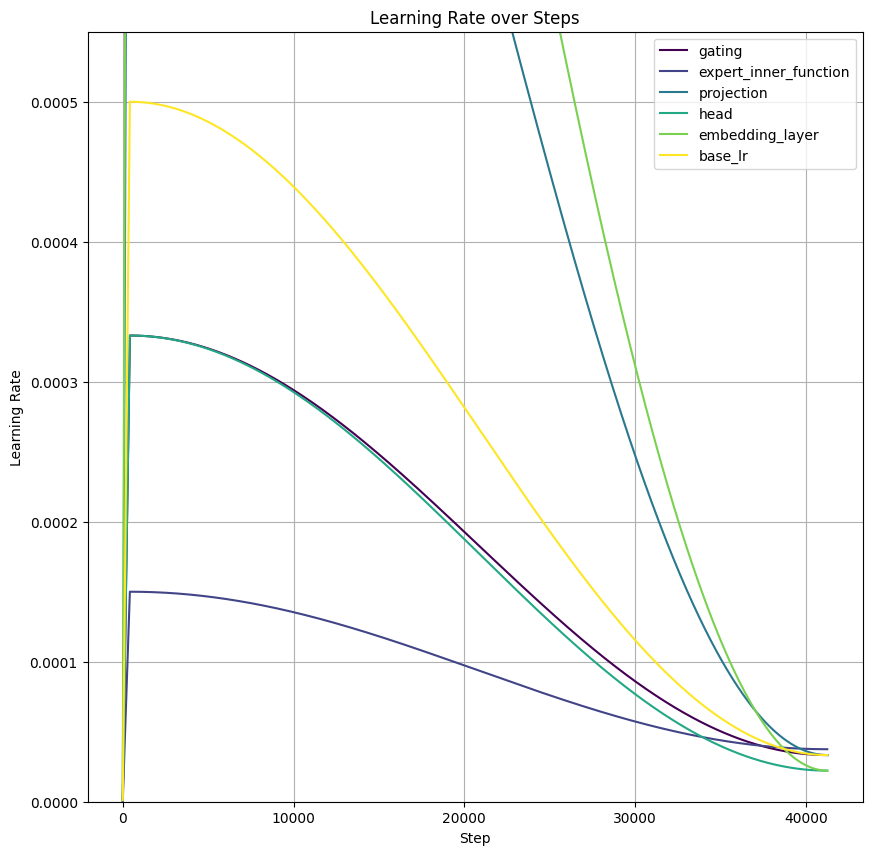

In [52]:
steps = range(0, other_dict['n_steps'] + 1)  # Steps from 0 to 1000
plt.figure(figsize=(10, 10))
max_lr = main_dict['lr']
colors = cm.viridis(np.linspace(0, 1, len(relative_dict)))

for idx, model_part in enumerate(relative_dict.keys()):
    print(model_part)
    scheduler = CosineScheduler(lr_warmup_steps=other_dict['lr_warmup_steps'],
                               lr=main_dict['lr'],
                               final_lr_step=other_dict['n_steps'],
                               final_lr_fraction=main_dict['fraction'],
                               ratio_lr=relative_dict[model_part]['lr'],
                               scheduler_fraction=relative_dict[model_part]['fraction'])
    model_part_lr_values = [scheduler.set_lr(step) for step in steps]
    plt.plot(steps, model_part_lr_values, label=model_part, color=colors[idx])
    if max_lr < main_dict['lr'] * relative_dict[model_part]['lr']:
        max_lr = main_dict['lr'] * relative_dict[model_part]['lr']

# plt.yscale('log')
# plt.ylim((0, max_lr * 1.1))
plt.ylim((0, main_dict['lr'] * 1.1))
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.grid(True)
plt.show()